# Perlin noise simulations

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm, trange

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

In [2]:
OUTDIR = '../out/'
DATADIR = '../data/'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

In [4]:
def get_main_grid(prefix):
    return pd.read_csv(DATADIR + 'main_grid_{}.dat'.format(prefix),
                       names=['x', 'y'], usecols=[0,1])
def get_sub_grid(prefix):
    return pd.read_csv(DATADIR + 'sub_grid_{}.dat'.format(prefix),
                       names=['x', 'y'], usecols=[0,1])
def get_cell_corners(prefix):
    return pd.read_csv(DATADIR + 'cell_corners_{}.dat'.format(prefix),
                       names=['u_left', 'u_right', 'b_left', 'b_right'], usecols=[0,1,2,3])
def get_grad_field(prefix):
    return pd.read_csv(DATADIR + 'gradient_field_{}.dat'.format(prefix),
                       names=['x', 'y'], usecols=[0,1])
def get_dot_field(prefix):
    return pd.read_csv(DATADIR + 'dot_grid_{}.dat'.format(prefix),
                       names=['x1', 'x2', 'x3', 'x4'], usecols=[0,1,2,3])
def get_ngp(prefix):
    return np.genfromtxt(DATADIR + 'ngp_{}.dat'.format(prefix), delimiter=',')[:-1]
def get_interp_grid(prefix):
    return np.genfromtxt(DATADIR + 'interp_grid_{}.dat'.format(prefix), delimiter=',')[:-1]
def get_flow_field(prefix):
    return pd.read_csv(DATADIR + 'flow_field_{}.dat'.format(prefix),
                       names=['x', 'y'], usecols=[0,1])

In [5]:
def get_coords(nrows, ncols,
               main, sub, grad, flow):
    
    # Create coord. system
    yc = np.arange(0,nrows,1)
    xc = np.arange(0,ncols,1)

    # Load in main grid coordinates
    x = main.x.values
    y = main.y.values
    
    # Load in sub grid coordinates
    xs = sub.x.values
    ys = sub.y.values
    
    # Load in gradient field vectors
    xg = grad.x.values
    yg = grad.y.values
    
    # Load flow field vectors
    xf = flow.x.values
    yf = flow.y.values
    
    return x,y,xs,ys,xg,yg,xf,yf

In [6]:
def get_ngp_for_dot(ngp, dot):
    
    i = pd.Series(['x{}'.format(int(gp+1)) for gp in ngp])
    
    return dot.lookup(i.index, i.values)

In [7]:
def load_data(prefix):
    
    main = get_main_grid(prefix)
    sub = get_sub_grid(prefix)
    cells = get_cell_corners(prefix)
    grad = get_grad_field(prefix)
    dot = get_dot_field(prefix)
    #ngp = get_ngp(prefix)
    interp = get_interp_grid(prefix)
    flow = get_flow_field(prefix)
    
    return main, sub, cells, grad, dot, interp, flow

In [34]:
# Size of grid
freq_i = 0
freqs = 4
nrows = 3 * 2**(freq_i)
ncols = 6 * 2**(freq_i)
res = 100

In [61]:
data = [load_data(prefix='{}'.format(2**i)) for i in range(0,freqs)]
dots_x1 = [d[-3]['x1'].values.reshape(res, res) for d in data]
dots_x2 = [d[-3]['x2'].values.reshape(res, res) for d in data]
dots_x3 = [d[-3]['x3'].values.reshape(res, res) for d in data]
dots_x4 = [d[-3]['x4'].values.reshape(res, res) for d in data]
interps = [d[-2].reshape(res, res) for d in data]

In [36]:
#analyzetree

In [37]:
x,y,xs,ys,xg,yg,xf,yf = get_coords(nrows=nrows, ncols=ncols,
                                   main=data[freq_i][0], sub=data[freq_i][1], grad=data[freq_i][3], flow=data[freq_i][6])

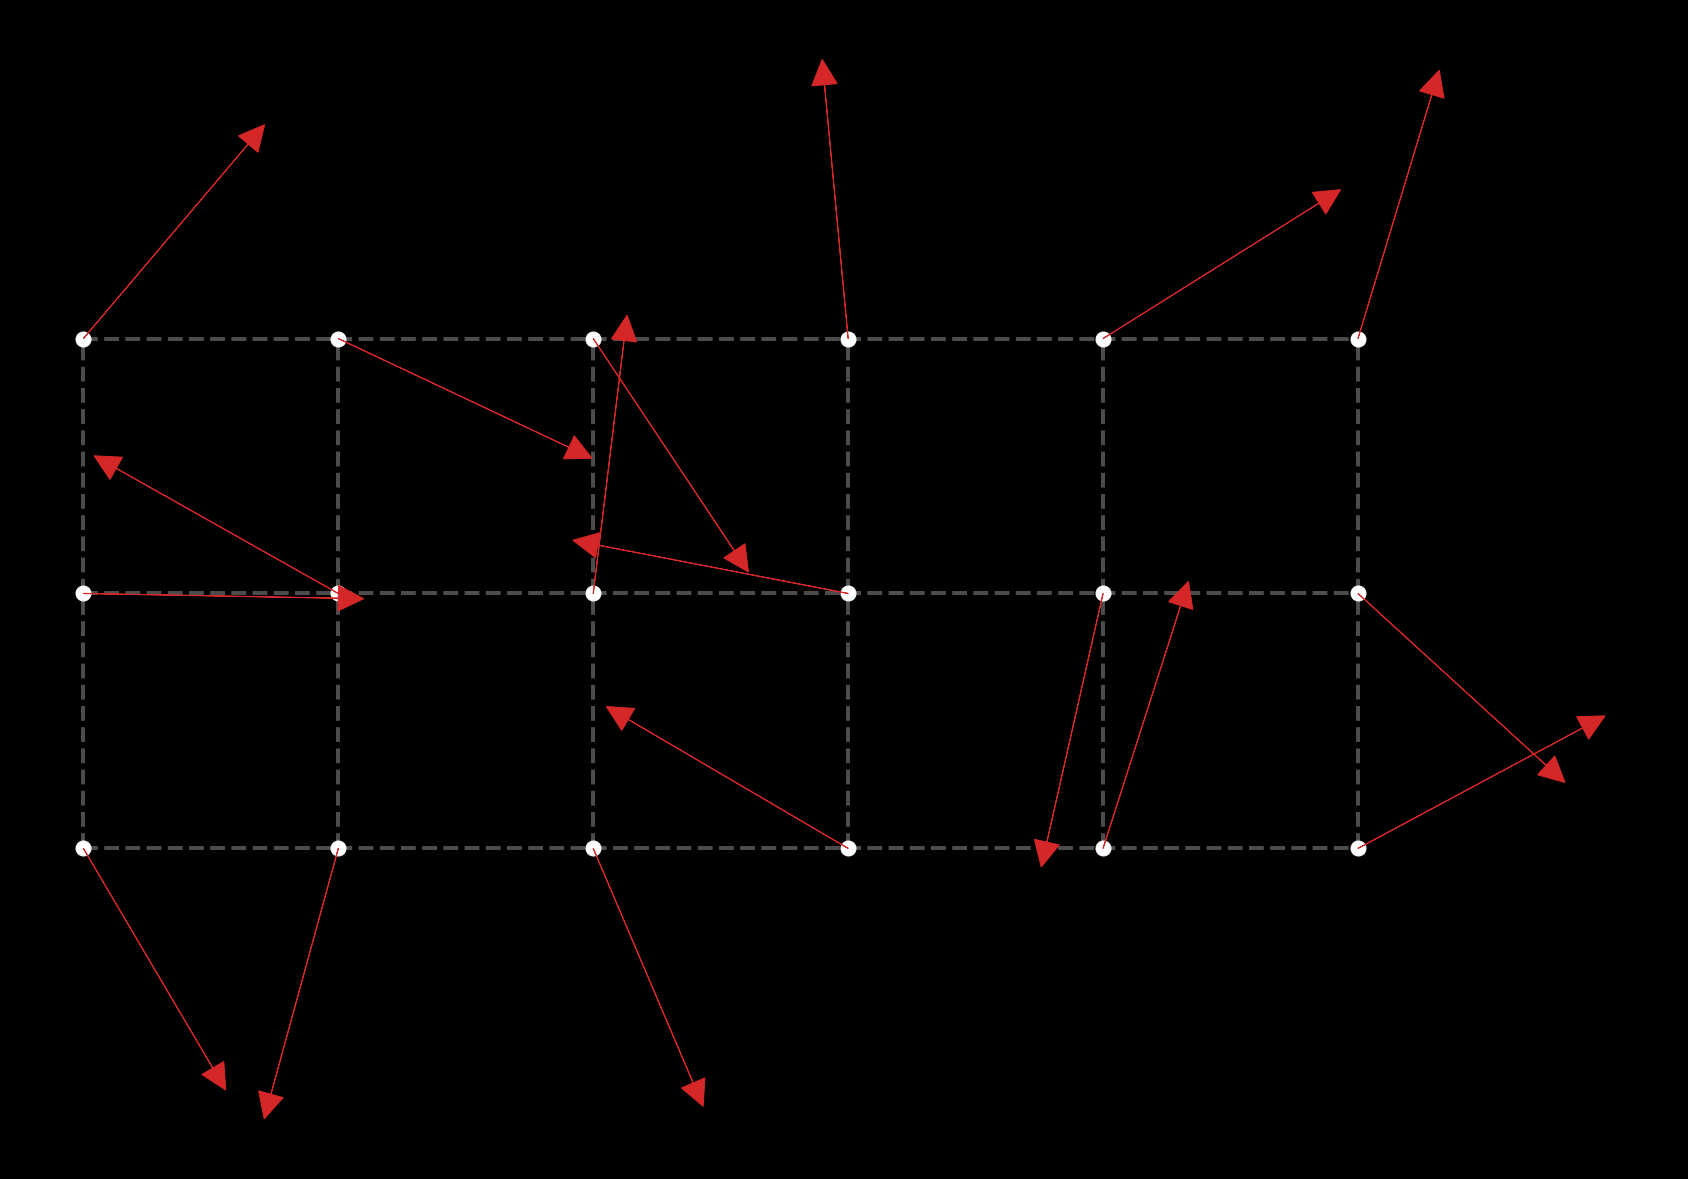

In [55]:
fig, axes = plt.subplots(figsize=(30,30),
                         facecolor='black')
axes.set_aspect('equal')
axes.axis('off')

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        axes.arrow(x=x[k], y=y[k], dx=xg[k], dy=yg[k],
                   color='tab:red', head_width=0.1, head_length=0.1, zorder=4)

# Draw coordinate grid points and gridlines between these points
plt.scatter(x, y,
            color='white', s=(15)**2)

for i in range(ncols):
    axes.plot([i, i], [0, nrows-1],
              color='white', ls='--', lw=4, alpha=0.3)
for i in range(nrows):
    axes.plot([0, ncols-1], [i, i],
              color='white', ls='--', lw=4, alpha=0.3)

plt.savefig(OUTDIR + 'perlin_mg_nr{}_nc{}_px{}.svg'.format(nrows, ncols, res),
            format='svg',
            dpi=100,
            facecolor='black',
            bbox_inches='tight')

plt.show()

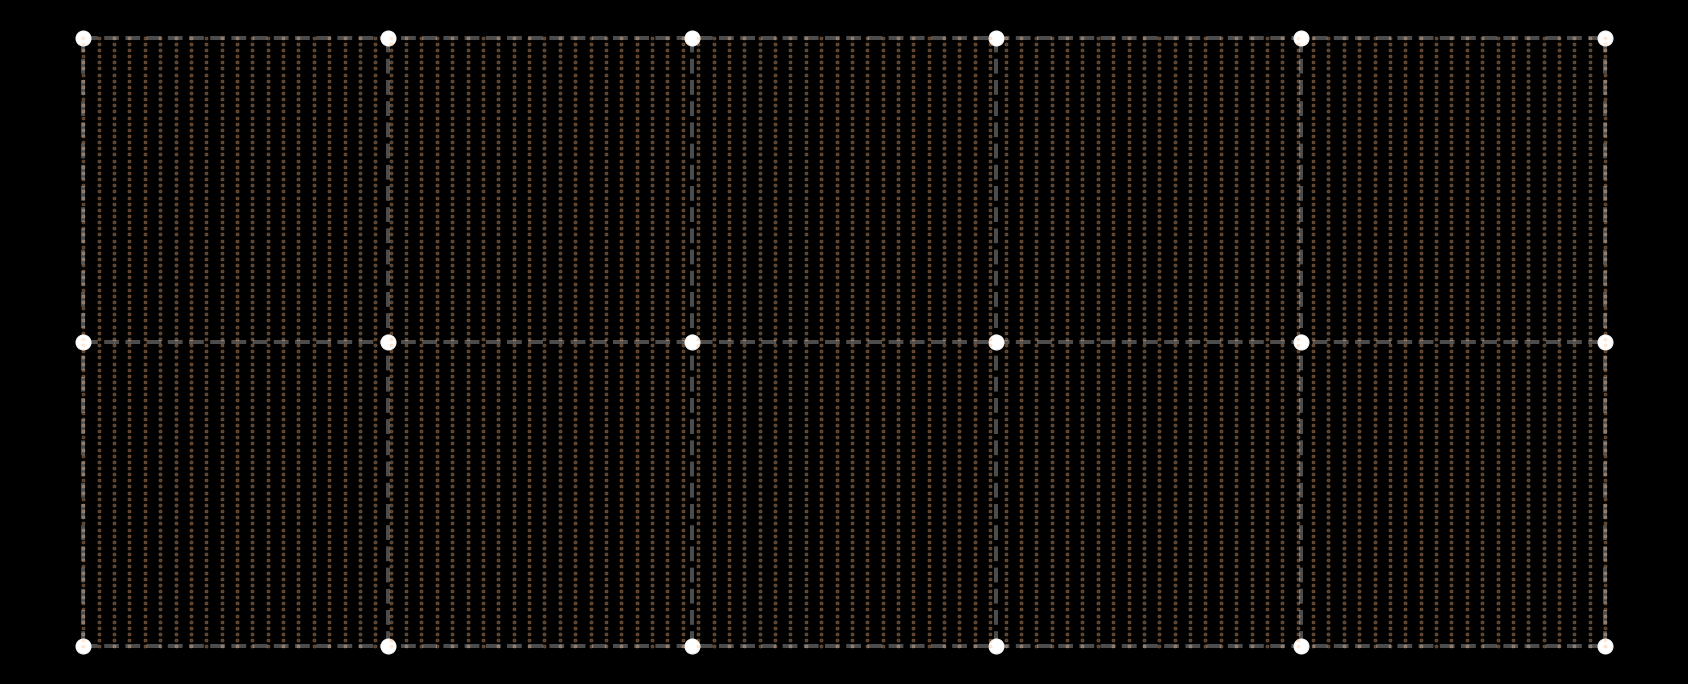

In [56]:
fig, axes = plt.subplots(figsize=(30,30),
                         facecolor='black')
axes.set_aspect('equal')
axes.axis('off')

#for i in range(nrows):
#    for j in range(ncols):
#        k = i * ncols + j
#        axes.arrow(x=x[k], y=y[k], dx=xg[k], dy=yg[k],
#                   color='tab:red', head_width=0.1, head_length=0.1, zorder=4)

# Draw coordinate grid points and gridlines between these points
plt.scatter(x, y,
            color='white', s=(15)**2)
plt.scatter(xs, ys,
            color=cm.magma(0.85), s=(3)**2, alpha=0.3)

for i in range(ncols):
    axes.plot([i, i], [0, nrows-1],
              color='white', ls='--', lw=4, alpha=0.3)
for i in range(nrows):
    axes.plot([0, ncols-1], [i, i],
              color='white', ls='--', lw=4, alpha=0.3)

# Mark the borders of the last cell
# (Should be seen in the upper right corner)
#for c in cells.iloc[-1]:
#    plt.scatter(coords.iloc[c].x, coords.iloc[c].y,
#                color='tab:green', s=(10)**2)
    
plt.savefig(OUTDIR + 'perlin_ms_nr{}_nc{}_px{}.svg'.format(nrows, ncols, res),
            format='svg',
            dpi=100,
            facecolor='black',
            bbox_inches='tight')

plt.show()

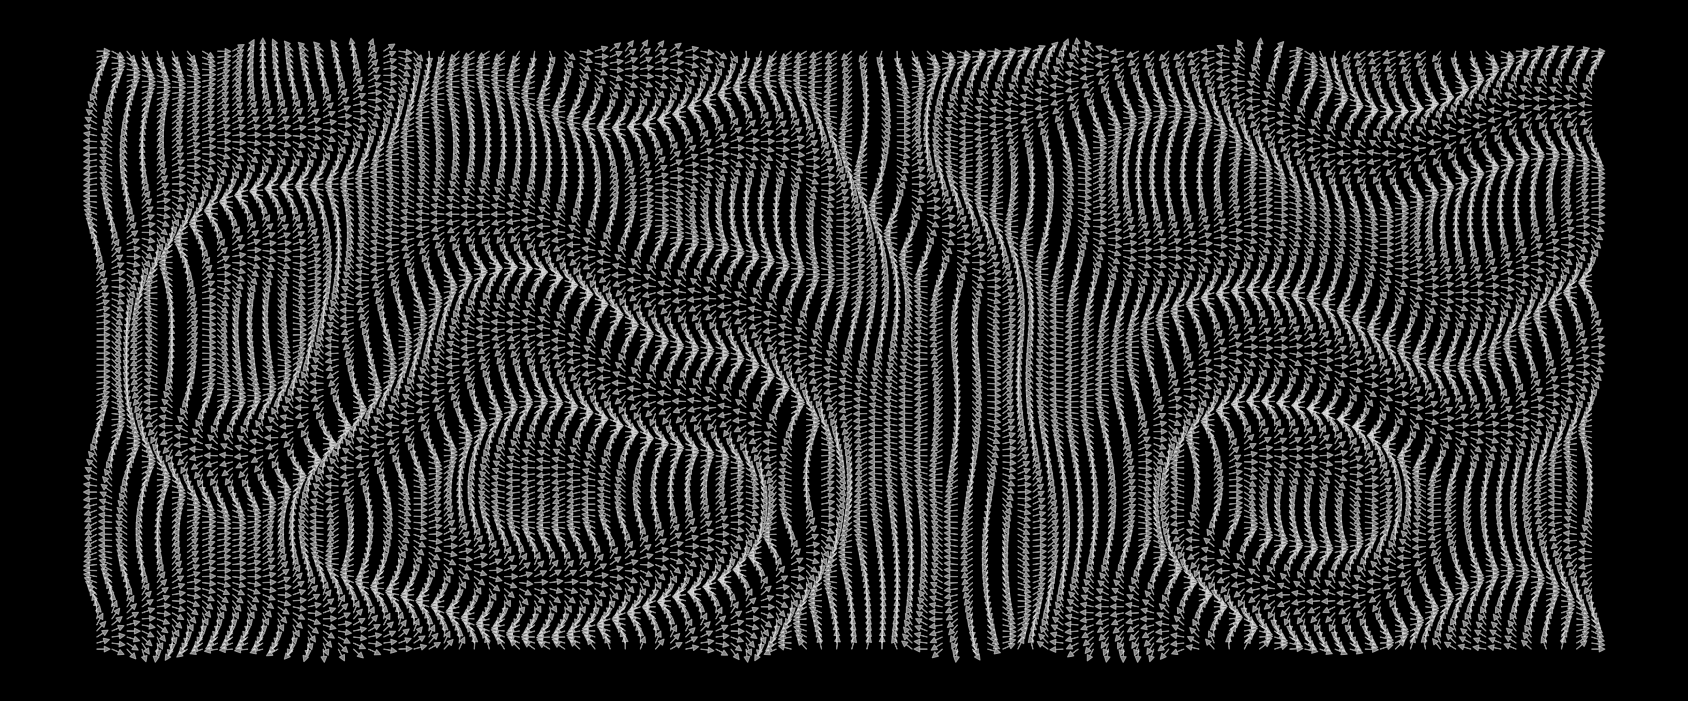

In [50]:
if res <= 100:
    fig, axes = plt.subplots(figsize=(30,30),
                             facecolor='black')
    axes.set_aspect('equal')
    axes.axis('off')

    for i in range(res):
        for j in range(res):
            k = i * res + j
            descale = 40
            axes.arrow(x=xs[k], y=ys[k], dx=xf[k]/descale, dy=yf[k]/descale,
                       color='white', head_width=0.02, head_length=0.02, alpha=0.5, zorder=4)

    plt.savefig(OUTDIR + 'perlin_f_nr{}_nc{}_px{}.svg'.format(nrows, ncols, res),
                format='svg',
                dpi=100,
                facecolor='black',
                bbox_inches='tight')

    plt.show()

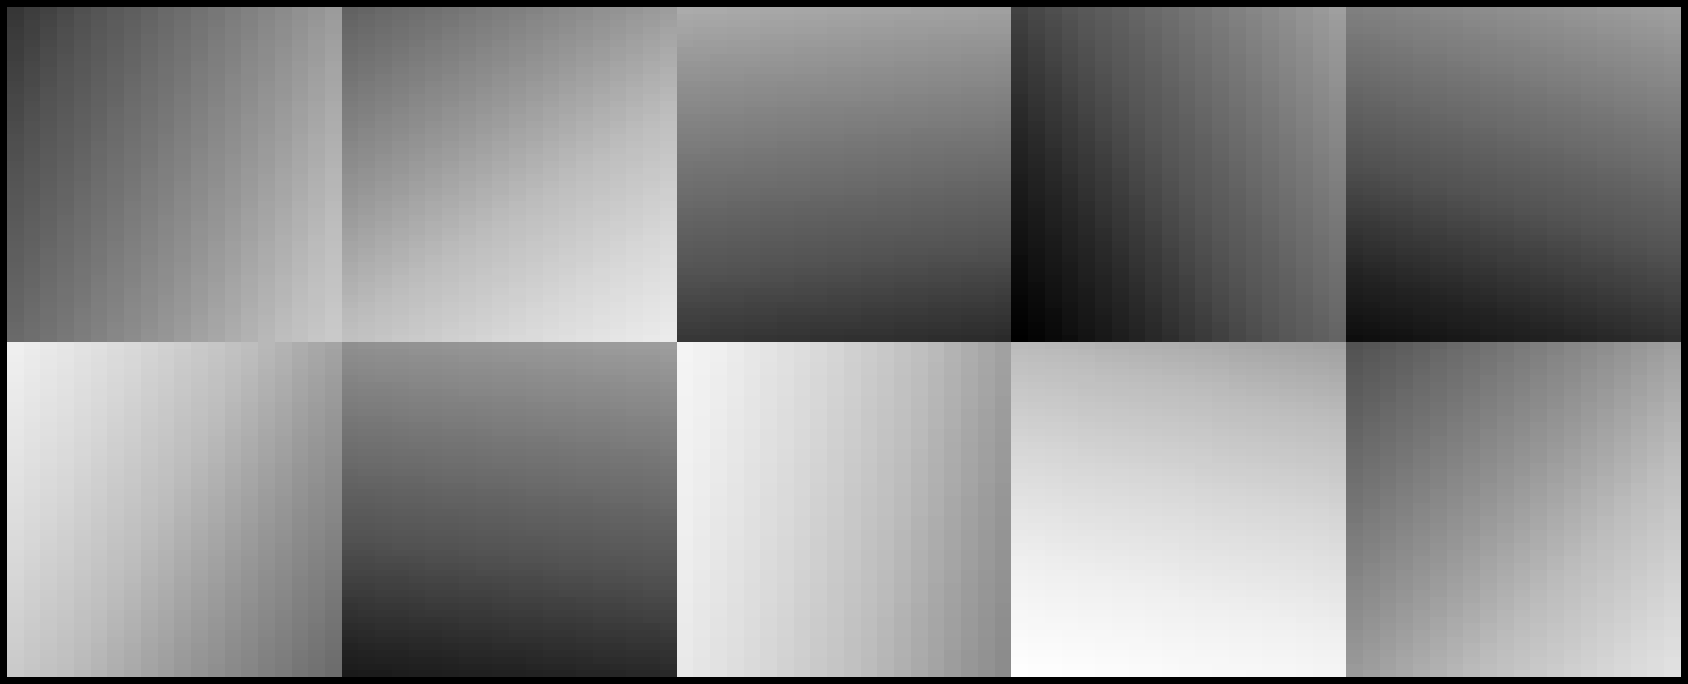

In [75]:
fig, axes = plt.subplots(figsize=(30,30),
                         facecolor='black')
axes.set_aspect('equal')
axes.axis('off')

axes.imshow(dots_x4[freq_i][::-1],
            extent=(0,ncols-1,0,nrows-1),
            cmap=cm.Greys)

plt.savefig(OUTDIR + 'perlin_d_nr{}_nc{}_px{}.png'.format(nrows, ncols, res),
            format='png',
            dpi=100,
            facecolor='black',
            bbox_inches='tight')

plt.show()

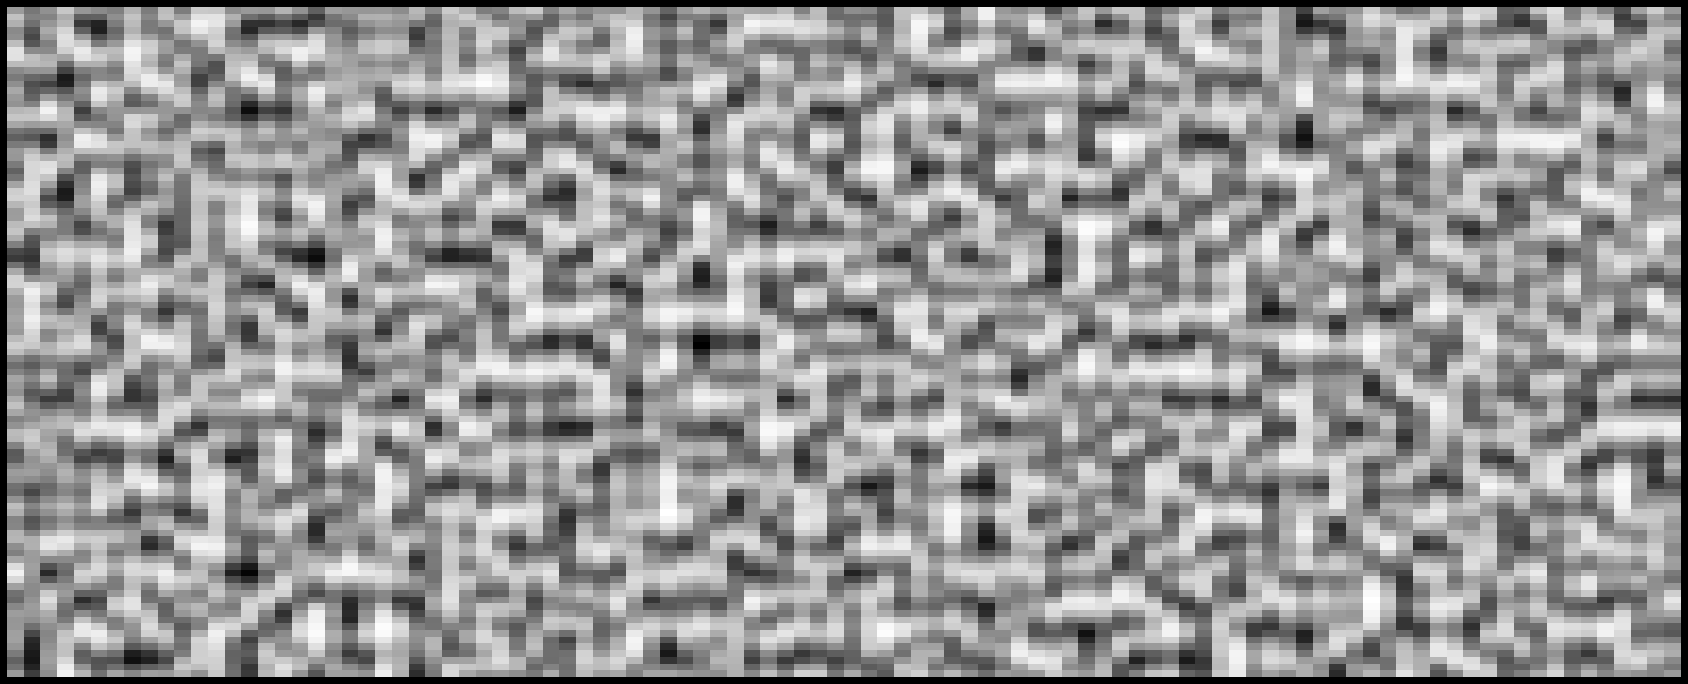

In [41]:
fig, axes = plt.subplots(figsize=(30,30),
                         facecolor='black')
axes.set_aspect('equal')
axes.axis('off')

for i, perlin in enumerate(interps):
    axes.imshow(perlin[::-1],
                extent=(0,ncols-1,0,nrows-1),
                cmap=cm.Greys)

    plt.savefig(OUTDIR + 'perlin_i{}_nr{}_nc{}_px{}.png'.format(i, nrows, ncols, res),
                format='png',
                dpi=100,
                facecolor='black',
                bbox_inches='tight')

plt.show()

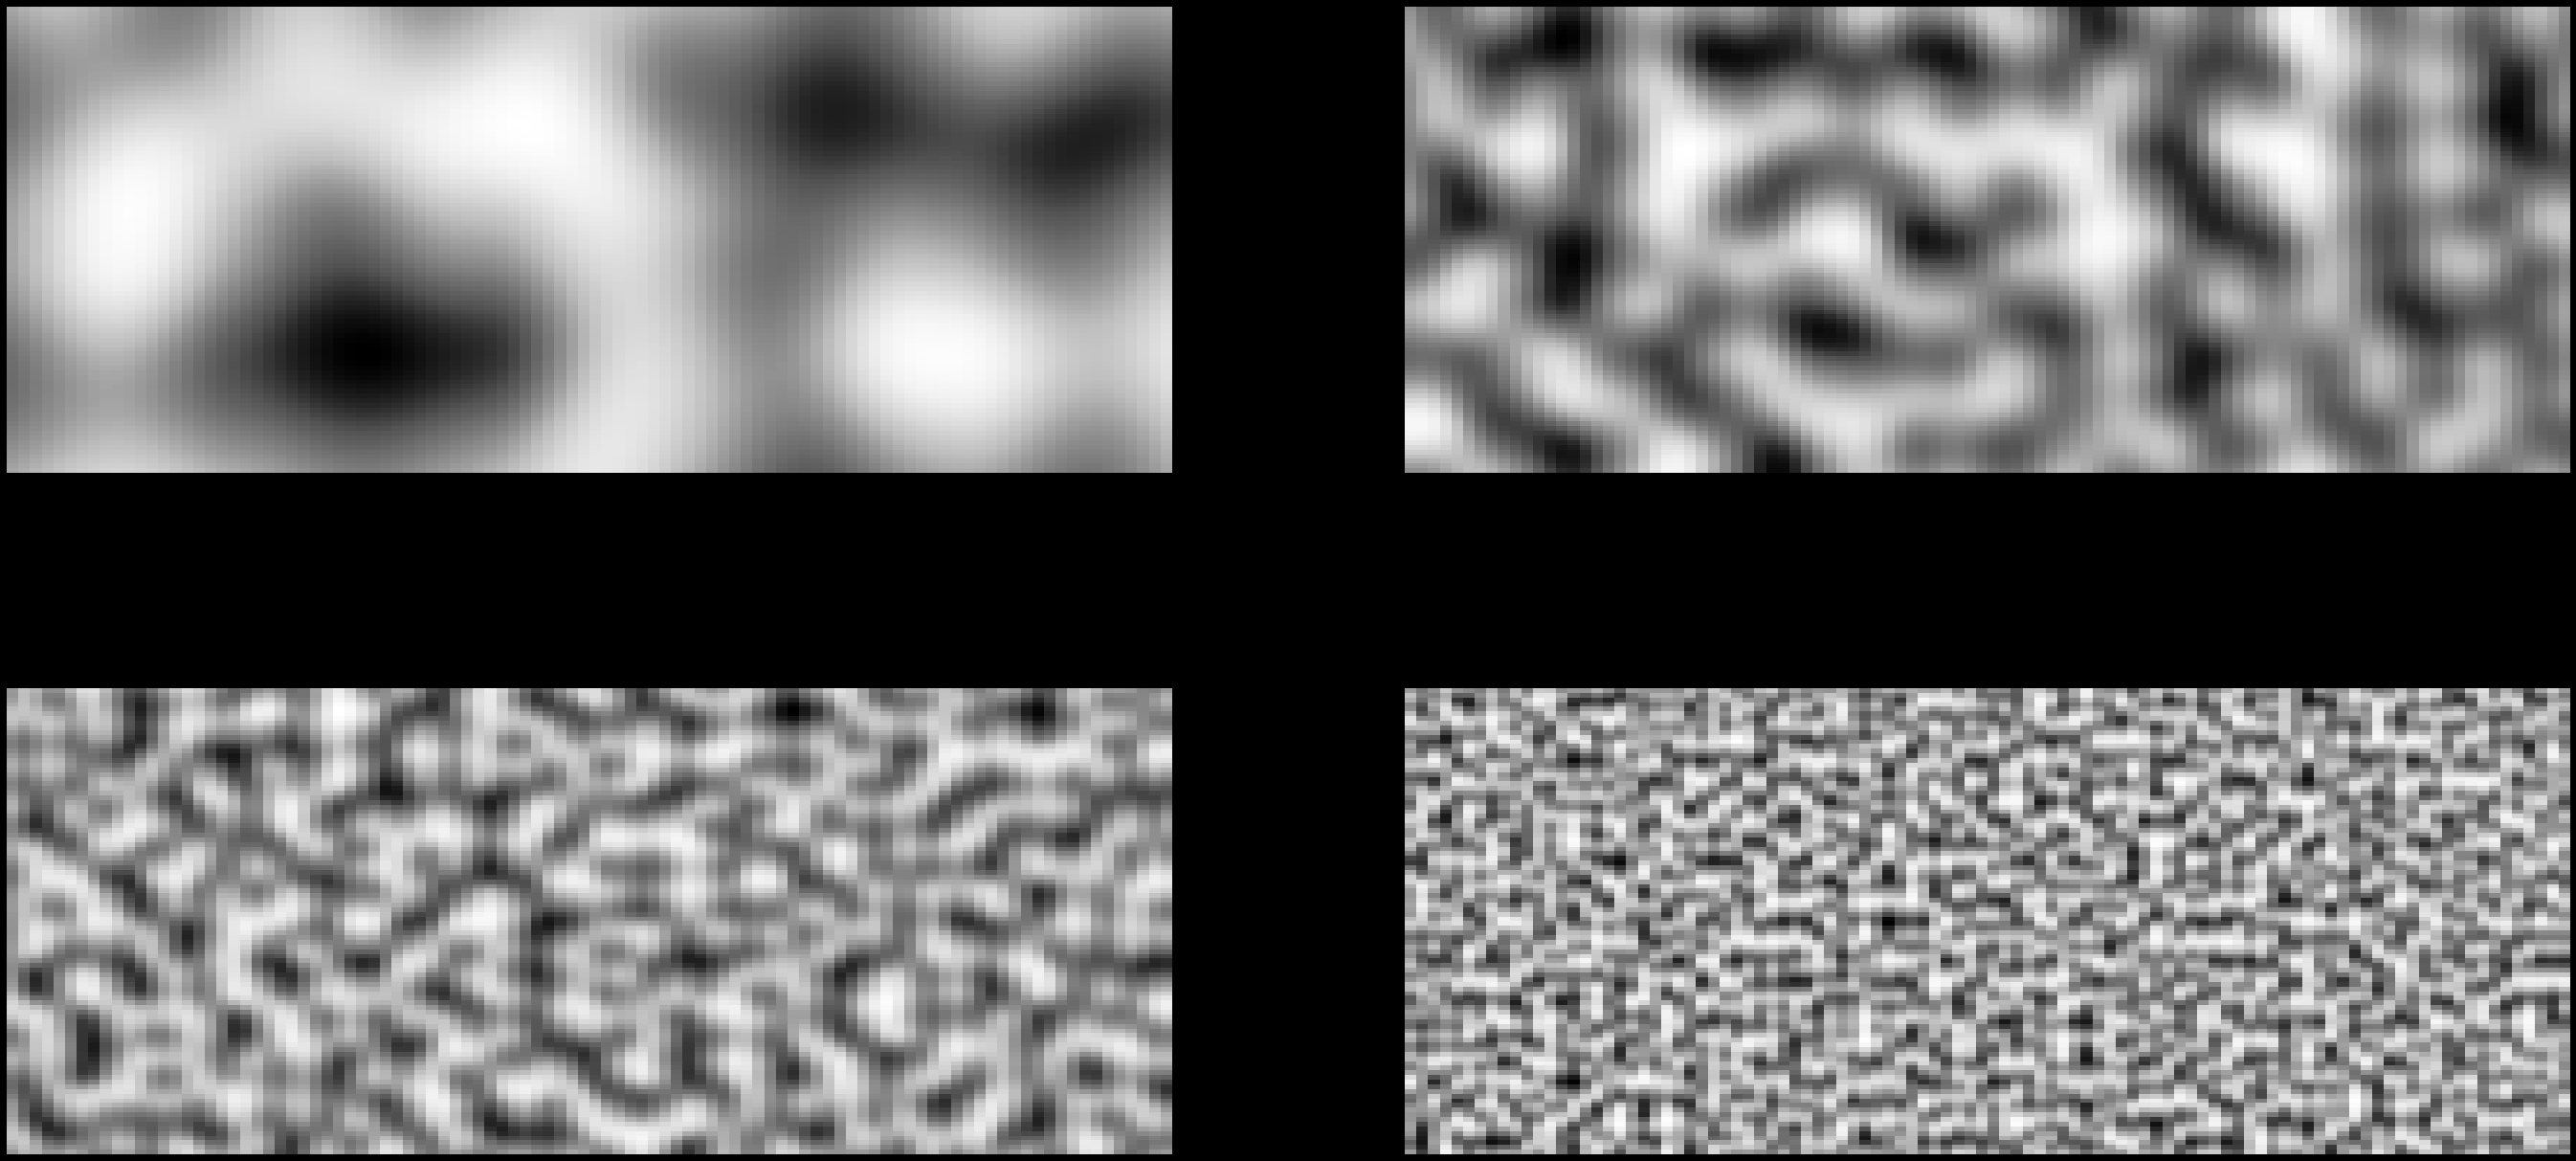

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(ncols*8, nrows*8),
                         facecolor='black')


for ax, i in zip(axes.reshape(-1), interps):
    ax.set_aspect('equal')
    ax.axis('off')

    ax.imshow(i[::-1], extent=(0,ncols-1,0,nrows-1),
              cmap=cm.Greys)

plt.savefig(OUTDIR + 'perlin_i_nr{}_nc{}_px{}.png'.format(nrows, ncols, res),
            format='png',
            dpi=100,
            facecolor='black',
            bbox_inches='tight')

plt.show()

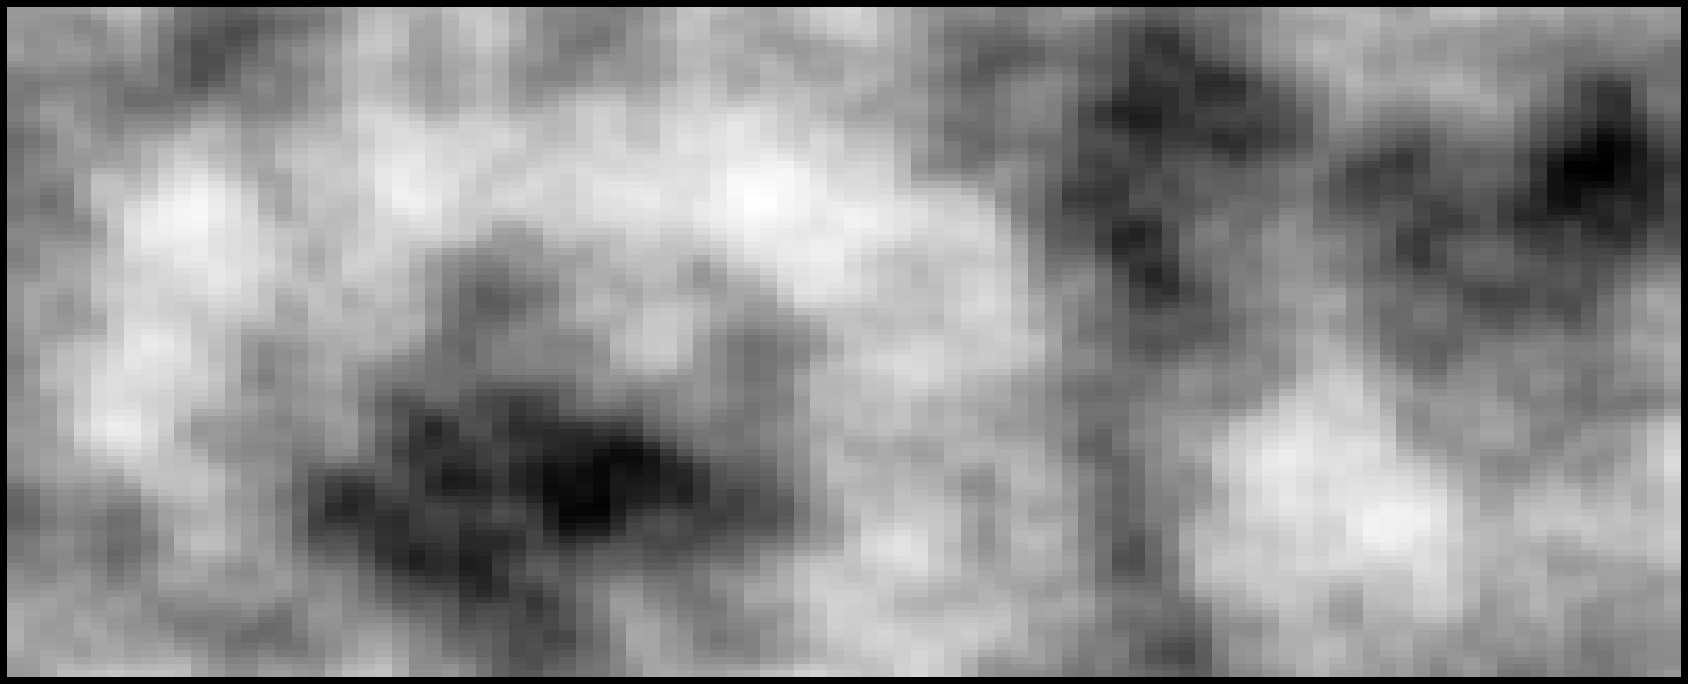

In [43]:
fig, axes = plt.subplots(figsize=(30,30),
                         facecolor='black')
axes.set_aspect('equal')
axes.axis('off')

fractal = np.zeros((res,res))
smooth = 2
for i, perlin in enumerate(interps):
    fractal += perlin*(1/smooth**i)
axes.imshow(fractal[::-1],
            extent=(0,ncols-1,0,nrows-1),
            cmap=cm.Greys)

plt.savefig(OUTDIR + 'perlin_iadd_nr{}_nc{}_px{}.png'.format(nrows, ncols, res),
            format='png',
            dpi=100,
            facecolor='black',
            bbox_inches='tight')

plt.show()

## Trace particles

In [18]:
PART_DIR = DATADIR + 'particles/'

In [19]:
def get_particle_pos():
    pos_x = np.genfromtxt(PART_DIR + 'pos_x.dat', delimiter=',')[:,:-1]
    pos_y = np.genfromtxt(PART_DIR + 'pos_y.dat', delimiter=',')[:,:-1]
    return pos_x, pos_y
def get_particle_vel():
    vel_x = np.genfromtxt(PART_DIR + 'vel_x.dat', delimiter=',')[:,:-1]
    vel_y = np.genfromtxt(PART_DIR + 'vel_y.dat', delimiter=',')[:,:-1]
    return vel_x, vel_y
def get_particle_acc():
    acc_x = np.genfromtxt(PART_DIR + 'acc_x.dat', delimiter=',')[:,:-1]
    acc_y = np.genfromtxt(PART_DIR + 'acc_y.dat', delimiter=',')[:,:-1]
    return acc_x, acc_y

In [20]:
pos_x, pos_y = get_particle_pos()

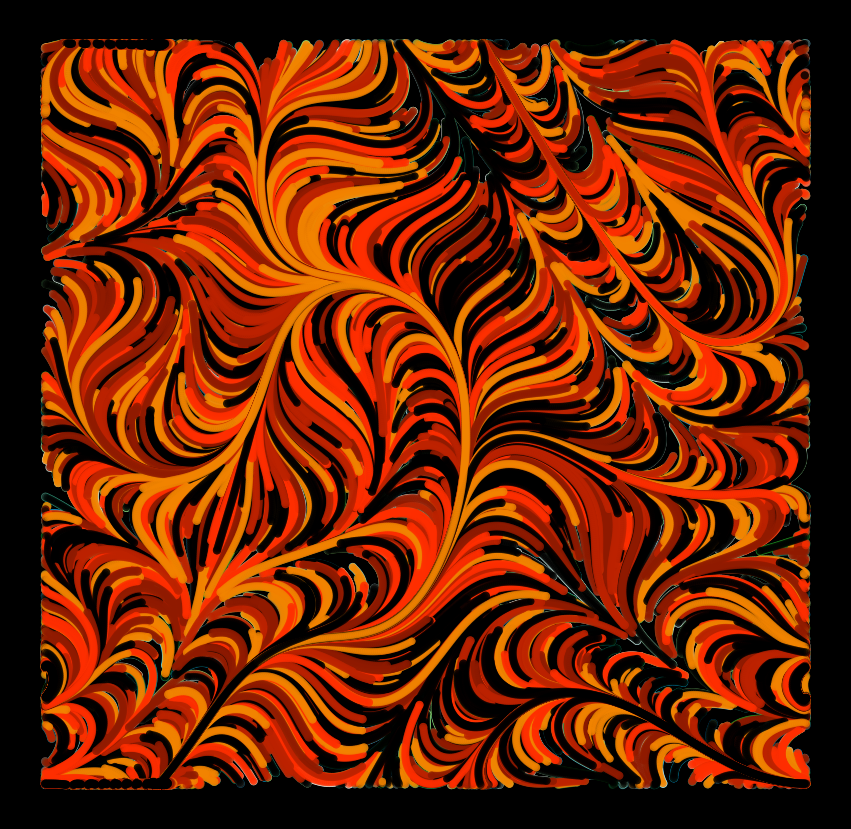

In [23]:
fig, axes = plt.subplots(figsize=(ncols*5, nrows*5),
                         facecolor='black', subplot_kw={'facecolor' : 'white'})
#axes.set_aspect('equal')
axes.axis('off')

#axes.imshow(interps[0][::-1], extent=(0,ncols-1,0,nrows-1),
#            cmap=cm.Greys)

# Color lists from here: https://github.com/punkduckable/PerlinFlowField/blob/main/Perlin_Flow_Field.py
#color_list = ['#005074','#58CBFF','#00B0FF','#285F78','#008AC8','#FFFFFF'];             # Shades of Blue
#color_list = ['#740050','#FF58CB','#FF00B0','#78285F','#C8008A','#FFFFFF'];             # Shades of Pink
#color_list = ['#16835E', '#50FF66', '#20782B', '#00C819', '#FFFFFF'];                   # Shades of Green
color_list = ['#219417','#B2EAAD', '#9CF179', '#086742', '#DAF0E0', '#15785D'];         # Greens and Teals ('#E8F0CB')
#color_list = ['#000000', '#000000', '#f28400', '#ff2e00', '#bd2200', '#901a00'];        # Lava (run with 3000+ particles or black background)
size_list = [55, 67, 69, 79]
xscale = (ncols-1)/(res-1)
yscale = (nrows-1)/(res-1)
for i in range(pos_x.shape[1]):
    plt.scatter(pos_x[:,i]*xscale, pos_y[:,i]*yscale,
                color=np.random.choice(color_list), edgecolor = 'None',
                s=np.random.choice(size_list), alpha=0.6)

save = True
if save:
    plt.savefig(OUTDIR + 'perlin_parts1_nr{}_nc{}_px{}.png'.format(nrows, ncols, res),
                format='png',
                dpi=100,
                facecolor='black')

plt.show()